In [1]:
Output = ('/Users/alexis/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/CEMALB_DataAnalysisPM/Projects/P1012. NC Well Arsenic/P1012.2. Analyses/P1012.2.3. ML Visualizations//Output')
cur_date = "022824"

library(readxl)
library(lubridate)
library(tidyverse)
library(randomForest)
library(e1071)
library(themis)

#reading in files
well_data = data.frame(read_excel("Input/Imputed_Well_Data_020924.xlsx")) 


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr   1.1.3     ✔ readr   2.1.4
✔ forcats 1.0.0     ✔ stringr 1.5.0
✔ ggplot2 3.4.3     ✔ tibble  3.2.1
✔ purrr   1.0.2     ✔ tidyr   1.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:dplyr’:

    combine


The following object is masked from ‘package:ggplot2’:

    margin


Loading required package: recipes


Attaching package: ‘recipes’


The following object is masked from ‘package:stringr’:

    fixed


The

In [2]:
head(well_data)

,Tax_ID,Health_Dept_ID,Permit_No,Water_Sample_Date,Casing_Depth,Well_Depth,Static_Water_Depth,Flow_Rate,pH,Metal,Longitude,Latitude,Geologic_Terrane,Rock_Type,Soil_Type_Condensed,Landuse_Condensed,Elevation,Stream_Distance,Concentration,Detect_Concentration
,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
1,4006015,344,09-192,NA,97,450,35,20.0,7.4,Ar,-80.55427,34.87224,CSB,MV,H,C,675.174,654.6816,2.007062,ND
2,04009002C,1525,14-18,12/7/10,65,300,32,2.0,7.0,Ar,-80.55676,34.87109,CSB,MV,D,C,678.113,454.1912,1.912321,ND
3,04030015C,1525,14-18,8/27/12,65,300,32,2.0,8.1,Ar,-80.55676,34.87109,CSB,MV,D,C,469.708,454.1912,7.000000,D
4,04030015J,1525,14-18,4/5/10,65,300,32,2.0,8.1,Ar,-80.55676,34.87109,CSB,MV,H,F,470.293,454.1912,1.153921,ND
5,04030020H,234,09-147,10/25/10,52,125,36,20.0,7.6,Ar,-80.55220,34.86012,CSB,MV,H,F,470.293,918.3419,1.675360,ND
6,4030041,1515,14-04,3/2/16,47,275,34,2.5,8.2,Ar,-80.56423,34.88559,CSB,MV,H,D,470.293,512.3955,14.000000,D


In supervised machine learning, decision boundaries help assess how well two predictors (on the x and y axis) separate different classes in classification. A clear decision boundary has most classes well separated.

In [3]:
arsenic_data = well_data %>%
     mutate(Five_Threshold = relevel(factor(ifelse(Concentration >= 5, 1, 0)), ref = "0"),
          Five_Threshold = relevel(factor(ifelse(Concentration >= 10, 1, 0)), ref = "0"),
           # making this col into a factor
          Detect_Concentration = relevel(factor(ifelse(Detect_Concentration == "D", 1, 0)), ref = "0"),
          # converting water sample date from a character to a date type 
          Water_Sample_Date = mdy(Water_Sample_Date)) %>%

    # filtering for Arsenic only
    filter(Metal == "Ar" & Landuse_Condensed != "NA") %>%
    select(-Metal)

head(arsenic_data)

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `Water_Sample_Date = mdy(Water_Sample_Date)`.
Caused by warning:
!  6 failed to parse.”


,Tax_ID,Health_Dept_ID,Permit_No,Water_Sample_Date,Casing_Depth,Well_Depth,Static_Water_Depth,Flow_Rate,pH,Longitude,⋯,Geologic_Terrane,Rock_Type,Soil_Type_Condensed,Landuse_Condensed,Elevation,Stream_Distance,Concentration,Detect_Concentration,Five_Threshold,Ten_Threshold
,<chr>,<dbl>,<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>
1,4006015,344,09-192,NA,97,450,35,20.0,7.4,-80.55427,⋯,CSB,MV,H,C,675.174,654.6816,2.007062,0,0,0
2,04009002C,1525,14-18,2010-12-07,65,300,32,2.0,7.0,-80.55676,⋯,CSB,MV,D,C,678.113,454.1912,1.912321,0,0,0
3,04030015C,1525,14-18,2012-08-27,65,300,32,2.0,8.1,-80.55676,⋯,CSB,MV,D,C,469.708,454.1912,7.000000,1,1,0
4,04030015J,1525,14-18,2010-04-05,65,300,32,2.0,8.1,-80.55676,⋯,CSB,MV,H,F,470.293,454.1912,1.153921,0,0,0
5,04030020H,234,09-147,2010-10-25,52,125,36,20.0,7.6,-80.55220,⋯,CSB,MV,H,F,470.293,918.3419,1.675360,0,0,0
6,4030041,1515,14-04,2016-03-02,47,275,34,2.5,8.2,-80.56423,⋯,CSB,MV,H,D,470.293,512.3955,14.000000,1,1,1


In [4]:
# creating dfs for each outcome
# dropped 2 rows that had missing dates
arsenic_detect_df = drop_na(arsenic_data[,c(4:15,19)]) 
arsenic_five_df = drop_na(arsenic_data[,c(4:15,20)]) 
arsenic_ten_df = drop_na(arsenic_data[,c(4:15,21)]) 

head(arsenic_five_df)

,Water_Sample_Date,Casing_Depth,Well_Depth,Static_Water_Depth,Flow_Rate,pH,Longitude,Latitude,Geologic_Terrane,Rock_Type,Soil_Type_Condensed,Landuse_Condensed,Five_Threshold
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<fct>
1,2010-12-07,65,300,32,2.0,7.0,-80.55676,34.87109,CSB,MV,D,C,0
2,2012-08-27,65,300,32,2.0,8.1,-80.55676,34.87109,CSB,MV,D,C,1
3,2010-04-05,65,300,32,2.0,8.1,-80.55676,34.87109,CSB,MV,H,F,0
4,2010-10-25,52,125,36,20.0,7.6,-80.55220,34.86012,CSB,MV,H,F,0
5,2016-03-02,47,275,34,2.5,8.2,-80.56423,34.88559,CSB,MV,H,D,1
6,2009-07-14,36,200,23,25.0,8.3,-80.58317,34.87103,CSB,MV,K,C,0


# Decision Boundary Calculation

In [8]:
# creating a df with variables that we're interested in 
# based on the highest predictors
highest_predictivity_data = data.frame(arsenic_five_df[,c("Longitude", "pH", "Five_Threshold")])
# well characteristic variables
well_char_data = data.frame(arsenic_five_df[,c("Casing_Depth", "Flow_Rate", "Five_Threshold")])

# using smote first to balance classes
balanced_highest_pred_data = smotenc(highest_predictivity_data, "Five_Threshold")
balanced_well_char_data = smotenc(well_char_data, "Five_Threshold")

# predicting
rf_detect_highest = randomForest(Five_Threshold~., data = balanced_highest_pred_data)
rf_detect_well_char = randomForest(Five_Threshold~., data = balanced_well_char_data)

In [9]:
# obtaining grid values and predictions visualize using ggplot
get_grid_df <- function(model, data, class = NULL, predict_type = "class",
  resolution = 100, showgrid = TRUE, ...) {

  # plotting original data
  if(!is.null(class)) cl <- data[,class] else cl <- 1
  data <- data[,1:2]
  k <- length(unique(cl))

  # make grid (between min and max for each variable)
  r <- sapply(data, range, na.rm = TRUE)
  xs <- seq(r[1,1], r[2,1], length.out = resolution)
  ys <- seq(r[1,2], r[2,2], length.out = resolution)
  g <- cbind(rep(xs, each = resolution), rep(ys, time = resolution))
  colnames(g) <- colnames(r)
  g <- as.data.frame(g)
    
  ### guess how to get class labels from predict
  ### (unfortunately not very consistent between models)
  p <- predict(model, g, type = predict_type)
  g$Pred_Class = p
    
  return(g)
}

# calling function
grid_df_highest = get_grid_df(rf_detect_highest, balanced_highest_pred_data, class = "Five_Threshold")
grid_df_well_char = get_grid_df(rf_detect_well_char, balanced_well_char_data, class = "Five_Threshold")

head(grid_df_highest)

,Longitude,pH,Pred_Class
,<dbl>,<dbl>,<fct>
1,-80.83541,5.400000,0
2,-80.83541,5.433333,0
3,-80.83541,5.466667,0
4,-80.83541,5.500000,0
5,-80.83541,5.533333,0
6,-80.83541,5.566667,0


# Decision Boundary Plot

Warning message:
“Removed 20 rows containing missing values (`geom_point()`).”


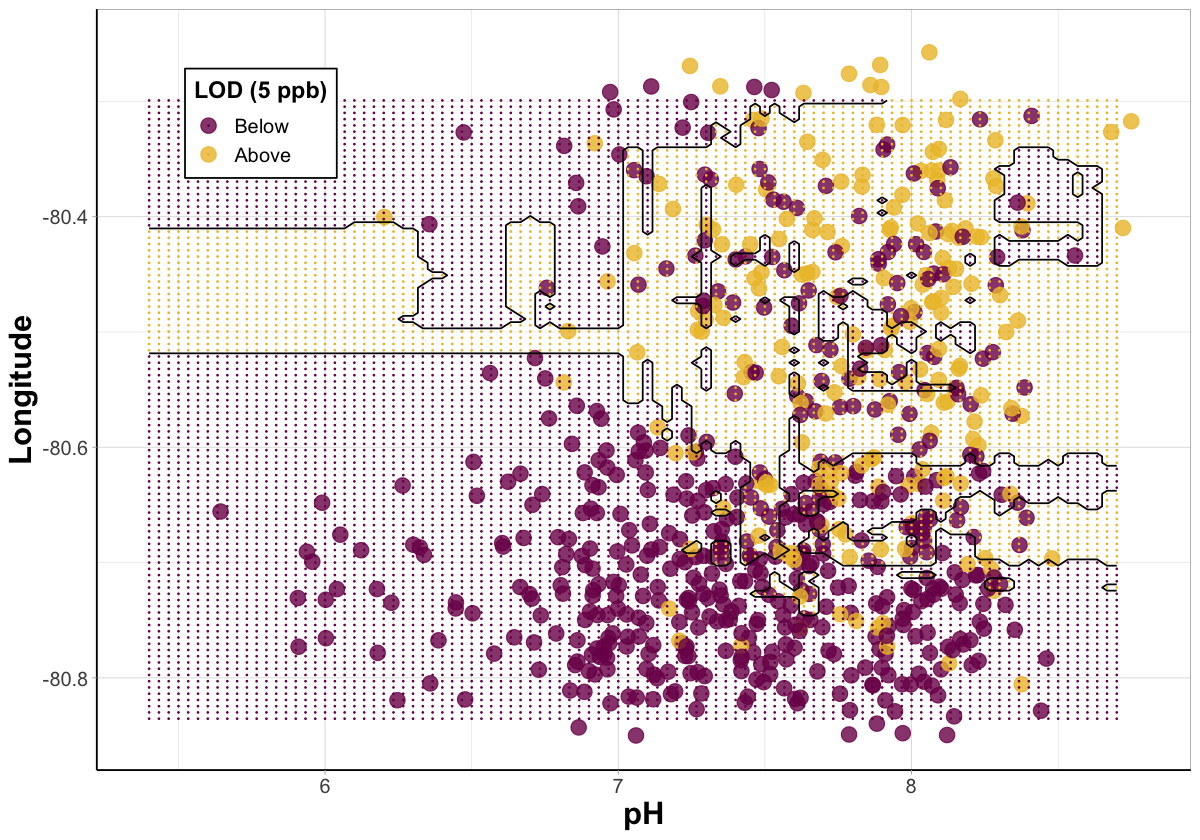

In [10]:
options(repr.plot.width=10, repr.plot.height=7) #changing size

ggplot() +
  geom_point(data = arsenic_five_df, aes(x = pH, y = Longitude, color = Five_Threshold),
            position = position_jitter(w = 0.1, h = 0.1), size = 4, alpha = 0.8) + 
  geom_contour(data = grid_df_highest, aes(x = pH, y = Longitude, z = as.numeric(Pred_Class == "1")), 
               color = "black", breaks = 0.5) + # adds contour line
  geom_point(data = grid_df_highest, aes(x = pH, y = Longitude, color = Pred_Class), 
             size = 0.1) + #shades plot
  #xlim(5.1, 8.7) + # changes the limits of the x axis
  ylim(-80.85, -80.25) + # changes the limits of the y axis

  theme_light() + 
  theme(axis.line = element_line(colour = "black"), #making x and y axes black
        axis.text = element_text(size = 12), #changing size of x axis labels
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        legend.title = element_text(face = 'bold', size = 14), #changes legend title
        legend.text = element_text(size = 12), #changes legend text
        legend.position = c(0.15,0.85), # move legend to top left corner
        legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
        strip.text.x = element_text(size = 15, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 15, face = "bold")) + #changes size of facet y axis 

scale_color_manual(name = "LOD (5 ppb)",
                      values = c('#7c1158', '#edbf33'),
                      labels = c('Below','Above'))  #reordering

Warning message:
“Removed 5600 rows containing non-finite values (`stat_contour()`).”
Warning message:
“Removed 8 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 5600 rows containing missing values (`geom_point()`).”


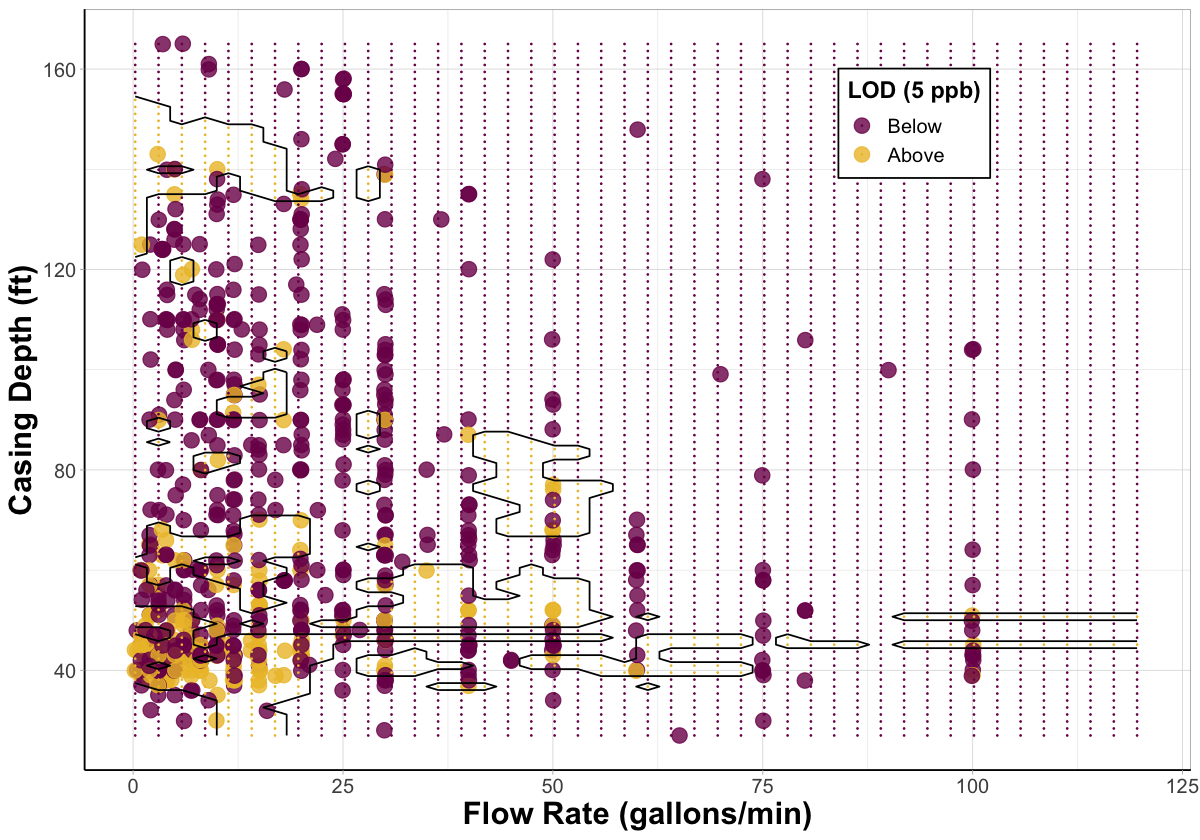

In [15]:
ggplot() +
  geom_point(data = arsenic_five_df, aes(x = Flow_Rate, y = Casing_Depth, color = Five_Threshold),
            position = position_jitter(w = 0.1, h = 0.1), size = 4, alpha = 0.8) + 
  geom_contour(data = grid_df_well_char, aes(x = Flow_Rate, y = Casing_Depth, z = as.numeric(Pred_Class == "1")), 
               color = "black", breaks = 0.5) + # adds contour line
  geom_point(data = grid_df_well_char, aes(x = Flow_Rate, y = Casing_Depth, color = Pred_Class), 
             size = 0.1) + #shades plot
  xlim(NA, 120) + # changes the limits of the x axis
  #ylim(-80.85, -80.25) + # changes the limits of the y axis

  theme_light() + 
  theme(axis.line = element_line(colour = "black"), #making x and y axes black
        axis.text = element_text(size = 12), #changing size of x axis labels
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        legend.title = element_text(face = 'bold', size = 14), #changes legend title
        legend.text = element_text(size = 12), #changes legend text
        legend.position = c(0.75,0.85), # move legend to top left corner
        legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
        strip.text.x = element_text(size = 15, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 15, face = "bold")) + #changes size of facet y axis 
  labs(x = 'Flow Rate (gallons/min)', y = 'Casing Depth (ft)') + #changing axis labels 

  scale_color_manual(name = "LOD (5 ppb)",
                      values = c('#7c1158', '#edbf33'),
                      labels = c('Below','Above'))  #reordering